In [1]:


import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from sklearn.manifold import TSNE

from tqdm import tqdm

from types import SimpleNamespace
import os, sys


In [2]:

project_dir = './msn'
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
os.chdir(project_dir)


In [3]:
config_path = os.path.join( 'output','proto20_embed64' ,'config.yaml')

with open(config_path, 'r') as f:
        config_dict = yaml.safe_load(f)
        config = SimpleNamespace(**config_dict)

In [4]:
config

namespace(alpha_ema=0.996,
          attn_drop_rate=0.0,
          batch_size=128,
          data_root='./../hsi_airborne/pca/',
          depth=6,
          drop_path_rate=0.0,
          drop_rate=0.0,
          embed_dim=64,
          epoch_stop_prototype=20,
          final_lr=1e-06,
          final_weight_decay=0.05,
          focal_crop_scale=[0.5, 0.6],
          focal_size=[15, 15, 32],
          focal_views=5,
          in_chans=1,
          lambda_reg=0.01,
          learning_rate=0.005,
          mask_ratio=0.5,
          mlp_ratio=4.0,
          num_epochs=100,
          num_heads=4,
          num_prototipos=20,
          num_workers=1,
          output_dir='./output/proto20_embed64',
          patch_size=[5, 5, 8],
          pin_memory=True,
          project_name='hsi-msn',
          rand_crop_scale=[0.8, 1.0],
          rand_size=[20, 20, 32],
          rand_views=2,
          resume_from=None,
          save_freq_epochs=50,
          spectral_jitter_strength=0.1,
       

## Load dataset

In [5]:
from src.dataset import init_data
from torch.utils.data import DataLoader

dataset = init_data(config_dict)


/home/emap/.pyenv/versions/hsi-msn/lib/python3.10/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
0it [00:00, ?it/s]

(128, 1, 32, 20, 20)


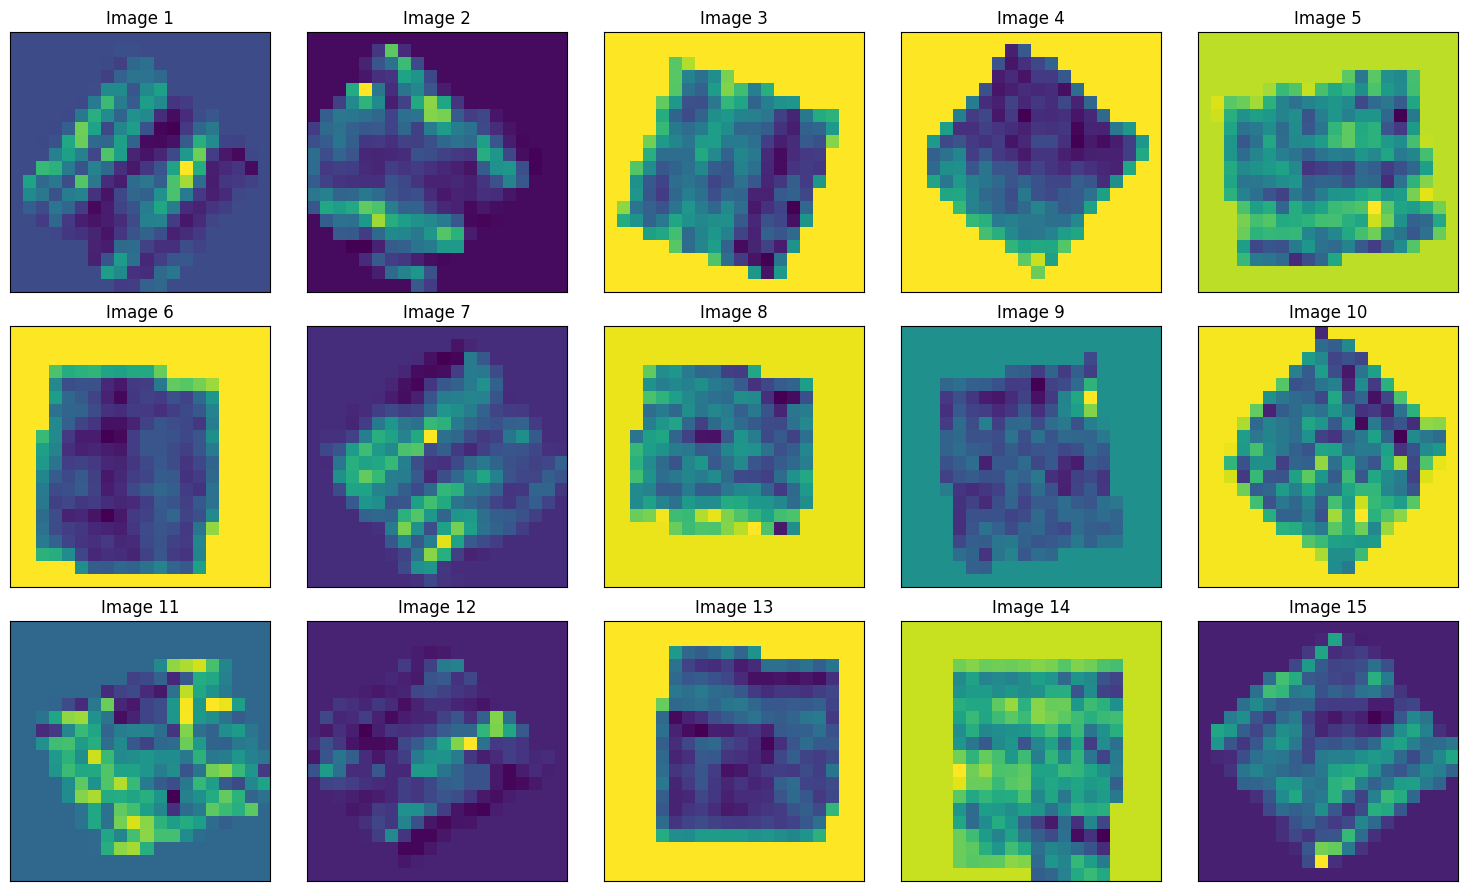

0it [00:00, ?it/s]


In [6]:
# the dataloader returns prisma_data, sentinel_data, airborne_data, 0

# plot 15 images from  airborne data  5x3 grid

#  withe theme

plt.style.use('default')


BAND_NUMBER = 2

for i, views in tqdm(enumerate(dataset)):
    views = [v for v in views]

     # shape [32, 1, 430, 20, 20] view[0] plot
     # view[0] to numpy

    view = views[0].detach().cpu().numpy()

    #plot
    print(view.shape)

    fig, axs = plt.subplots(3, 5, figsize=(15, 9))
    axs = axs.flatten()
    for j in range(15):
        axs[j].imshow(view[j,0, BAND_NUMBER, :, :])
        axs[j].set_title(f'Image {j+1}')
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    plt.tight_layout()
    plt.show()

    break

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#device = "cpu"
from src.hsi_msn import MSNModel

model = MSNModel(config).to(device)


checkpoint_path = f"{config.output_dir}/min_loss_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])



rand_pos_embed torch.Size([1, 64, 64])


<All keys matched successfully>

In [8]:
checkpoint["epoch"]

90

In [9]:
prot = model.prototypes
prot = prot.to(device)
prot = torch.nn.functional.normalize(prot, dim = 0 )
prot.shape

torch.Size([20, 64])

In [10]:
model.eval()

E = torch.empty(0, config.embed_dim).to(device)
F = torch.empty(0, prot.shape[0]).to(device)


count = 0

with torch.no_grad():

    # 10% dos dados
    for i , views in tqdm(enumerate(dataset)):
        count += 1

         # shape [32, 1, 430, 20, 20] view[0] plot
         # view[0] to numpy

        views = views[0].to(device)
        z_views = model.target_encoder(views)

        z_views = torch.nn.functional.normalize(z_views, dim=1)

        E = torch.cat((E, z_views), 0)

        F = torch.cat((F, z_views @ prot.T), 0)

        # if count == 20:
        #     break


15it [00:02,  6.17it/s]


In [11]:
# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).detach().numpy()

# Apply TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(data)

# Separate the results for prototypes and latent points
tsne_E = tsne_results[:E.shape[0]]
tsne_prot = tsne_results[E.shape[0]:]


In [12]:
# value count clsuter labels

cluster_labels = torch.argmax(F, dim=1).cpu().numpy()     
cluster_labels = pd.Series(cluster_labels)
cluster_counts = cluster_labels.value_counts().sort_index()
print(cluster_counts) 

0     159
1      73
2      74
3      27
4      45
5      51
6      90
7      51
8     126
9      72
10    126
11    287
12     54
13    168
14     56
15    126
16     49
17     25
18    176
19     41
Name: count, dtype: int64


In [13]:
# read train_gt.csv

train_gt_path = os.path.join( './../train_gt.csv')
train_gt = pd.read_csv(train_gt_path)


train_gt = train_gt[0:len(E)]

In [14]:
train_gt

,sample_index,B,Cu,Zn,Fe,S,Mn
0,0,0.8,2.1,5.0,186.6,12.078640,110.7
1,1,0.6,3.5,7.3,255.6,12.199673,75.7
2,2,0.5,2.1,2.3,204.0,65.882013,87.1
3,3,0.8,1.9,3.3,165.6,31.942712,56.0
4,4,0.5,2.4,5.8,419.9,35.970698,65.1
...,...,...,...,...,...,...,...
1871,1871,0.6,2.6,2.6,225.4,31.778477,99.9
1872,1872,0.5,2.4,3.0,204.2,30.832575,94.2
1873,1873,0.6,2.6,6.1,298.9,10.246492,64.3
1874,1874,0.8,1.8,6.0,184.6,10.098610,125.3


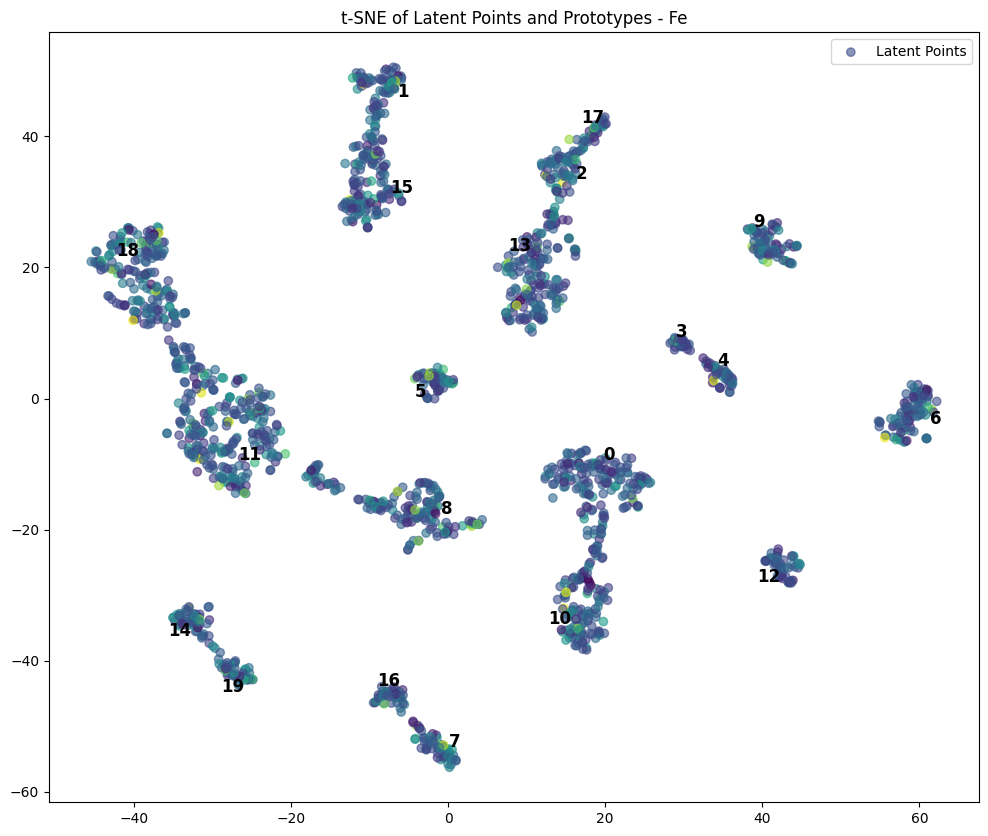

In [ ]:

elemento = 'B'


# Plotar os resultados do t-SNE
cluster_labels = train_gt[elemento]
plt.figure(figsize=(12, 10))

# quero um cmap pra classes 
# Use 'c' para o mapeamento de cores e guarde o objeto do scatter plot
scatter = plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c=cluster_labels, cmap='viridis', label='Latent Points', alpha=0.6)

# # # Adiciona a barra de cores and title
# cbar = plt.colorbar(scatter)
# cbar.set_label(elemento, rotation=270, labelpad=15) # Adiciona um rótulo à barra de cores



# Adiciona os protótipos ao gráfico
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes - {elemento}".format(elemento=elemento))

# title colorbar label
#cbar.set_label(elemento, rotation=270, labelpad=15)

# Salva a figura em um arquivo
plt.savefig('tsne_plot.png')
